# Summary 

Research Question: Will all of the features provide more predictive power for ad clicks than a subset of the features?

Conclusion: All of the features provided in the dataset used together were better at predicting ad clicks than a subset of features. To arrive at this conclusion I first removed the `Country` feature because there were over 200 unique values and some of these values were noisy. For example, there were some countries that had only one observation, so I decided this feature wouldn't have much predictive power. Then, I implemented an RFE feature selection model to find the most important features. This model selected `Daily Time Spent on Site`, `Age`, `Male` as the three most important features. When I trained a logistic regression model on these features I got 89% accuracy, but when I used all of the features, I got 92% accuracy. Then, just to make sure there wasn't a single feature dominating all of the prediction, I tried training a model using only the `Area Income` variable. This yielded a 55% accuracy, showing that more variables are necessary to predict clicks. This result might seem counterintuitive since most of these variables were correlated with each other, so one might think some of the variables are redundant. This project shows that sometimes feature selection algorithms can provide worse results than hand selecting features. Feature selection is more of an art than a science and requires a lot of experimentation and domain knowledge. For future data science projects we shouldn't blindly trust feature selection algorithms like RFE. 

In [204]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

advertising_data = pd.read_csv("data/advertising data.csv")

# Exploratory Data Analysis

## Variable and type exploration

In [169]:
advertising_data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Country,Clicked on Ad
0,68.95,35,61833.90,256.09,0,Tunisia,0
1,80.23,31,68441.85,193.77,1,Nauru,0
2,69.47,26,59785.94,236.50,0,San Marino,0
3,74.15,29,54806.18,245.89,1,Italy,0
4,68.37,35,73889.99,225.58,0,Iceland,0


In [170]:
print("(number of observations, number of variables):")
print(advertising_data.shape)
print("\nvariable names:")
print(advertising_data.columns)
print("\ndata types:")
print(advertising_data.dtypes)

(number of observations, number of variables):
(1000, 7)

variable names:
Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Male', 'Country', 'Clicked on Ad'],
      dtype='object')

data types:
Daily Time Spent on Site    float64
Age                           int64
Area Income                 float64
Daily Internet Usage        float64
Male                          int64
Country                      object
Clicked on Ad                 int64
dtype: object


In [171]:
print("number of unique countries:")
advertising_data['Country'].nunique()

number of unique countries:


237

In [172]:
print("dropping country data because it's too noisy")
advertising_data = advertising_data.drop('Country', axis=1)

dropping country data because it's too noisy


## Summary Stats of Numeric variables

In [173]:
numeric_cols = ["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage"]
advertising_data[numeric_cols].describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,65.000200,36.009000,55000.000080,180.000100
std,15.853615,8.785562,13414.634022,43.902339
min,32.600000,19.000000,13996.500000,104.780000
25%,51.360000,29.000000,47031.802500,138.830000
50%,68.215000,35.000000,57012.300000,183.130000
75%,78.547500,42.000000,65470.635000,218.792500
max,91.430000,61.000000,79484.800000,269.960000


## Correlation of Numeric Variables

In [174]:
advertising_data[numeric_cols].corr()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
Daily Time Spent on Site,1.000000,-0.331513,0.310954,0.518658
Age,-0.331513,1.000000,-0.182605,-0.367209
Area Income,0.310954,-0.182605,1.000000,0.337496
Daily Internet Usage,0.518658,-0.367209,0.337496,1.000000


internet usage and income visualization


<AxesSubplot:xlabel='Area Income', ylabel='Daily Internet Usage'>

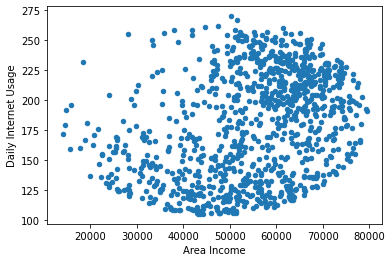

In [175]:
print("internet usage and income visualization")
advertising_data.plot.scatter(x='Area Income', y="Daily Internet Usage")

internet usage and age visualization


<AxesSubplot:xlabel='Age', ylabel='Daily Internet Usage'>

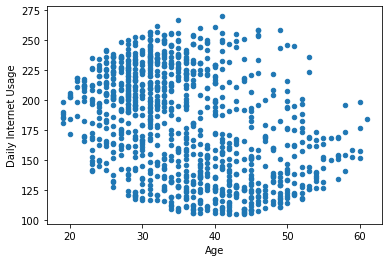

In [176]:
print("internet usage and age visualization")
advertising_data.plot.scatter(x='Age', y="Daily Internet Usage")

## Distribution of Numeric Variables

Age distribution:


<AxesSubplot:>

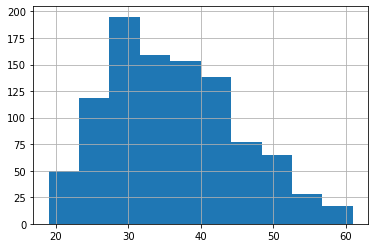

In [177]:
print("Age distribution:")
advertising_data["Age"].hist()

Area Income Distribution:


<AxesSubplot:>

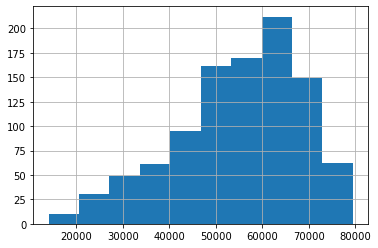

In [178]:
print("Area Income Distribution:")
advertising_data['Area Income'].hist()

Daily Internet Usage Distribution:


<AxesSubplot:>

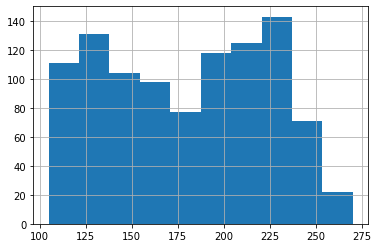

In [179]:
print("Daily Internet Usage Distribution:")
advertising_data['Daily Internet Usage'].hist()

Daily Time Spent on Site Distribution:


<AxesSubplot:>

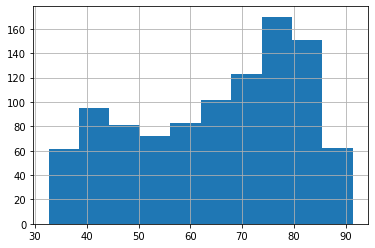

In [180]:
print("Daily Time Spent on Site Distribution:")
advertising_data['Daily Time Spent on Site'].hist()

## Comparing Clicks vs No Clicks

In [181]:
advertising_data.groupby("Clicked on Ad").mean()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male
Clicked on Ad,,,,,
0,76.85462,31.684,61385.58642,214.51374,0.500
1,53.14578,40.334,48614.41374,145.48646,0.462


## Distribution of Classes

<AxesSubplot:>

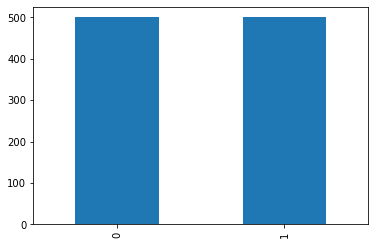

In [182]:
advertising_data["Clicked on Ad"].value_counts().plot.bar()

## Implementing the Model

In [183]:
X = advertising_data.loc[:, advertising_data.columns != 'Clicked on Ad']
y = advertising_data['Clicked on Ad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Recursive Feature Elimination

In [184]:
logit = LogisticRegression()
rfe = RFE(logit, n_features_to_select=3)
rfe_model = rfe.fit(X_train, y_train.values.ravel())
print(rfe_model.support_)
print(rfe_model.ranking_)

[ True  True False False  True]
[1 1 3 2 1]


In [193]:
selected_columns = [list(X.columns)[i] for i in range(len(X.columns)) if rfe_model.support_[i] == True]
print(selected_columns)

['Daily Time Spent on Site', 'Age', 'Male']


### Training the Model

In [186]:
X_train_reduced = X_train[selected_columns]
X_test_reduced = X_test[selected_columns]

In [187]:
X_train_reduced = X_train[selected_columns]
X_test_reduced = X_test[selected_columns]

logreg = LogisticRegression()
logreg.fit(X_train_reduced, y_train)

y_pred_reduced = logreg.predict(X_test_reduced)
print('Accuracy of logistic regression classifier on test set with reduced data from rfe on test set: {:.2f}'.format(logreg.score(X_test_reduced, y_test)))

Accuracy of logistic regression classifier on test set with reduced data from rfe on test set: 0.89


In [211]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set with all data on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set with all data on test set: 0.92


In [205]:
X_train_single_feature = np.array(X_train['Area Income']).reshape(-1, 1)
X_test_single_feature = np.array(X_test['Area Income']).reshape(-1,1)

logreg = LogisticRegression()
logreg.fit(X_train_single_feature, y_train)

y_pred_single_feature = logreg.predict(X_test_single_feature)
print('Accuracy of logistic regression classifier on test set with a single feature on test set: {:.2f}'.format(logreg.score(X_test_single_feature, y_test)))

Accuracy of logistic regression classifier on test set with all data on test set: 0.55


### Evaluating Model

In [189]:
print("trained on features selected from rfe evaluation")
confusion_matrix_reduced = confusion_matrix(y_test, y_pred_reduced)
print(confusion_matrix_reduced)

trained on features selected from rfe evaluation
[[152  12]
 [ 22 114]]


In [190]:
print("trained on all features")
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

trained on all features
[[155   9]
 [ 16 120]]


### Final Model Performance

In [192]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       164
           1       0.93      0.88      0.91       136

    accuracy                           0.92       300
   macro avg       0.92      0.91      0.92       300
weighted avg       0.92      0.92      0.92       300

